<a href="https://colab.research.google.com/github/jcorner1/PhD_UVA_Repo/blob/main/Anchors_SST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install wget
import wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=7d7ce3f37e00925b3ad3a2b9176ad907f61d5c525b4d592bc19cf93a96fd5ae2
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
# Define the remote file to retrieve
remote_url = 'https://eabarnes-data.atmos.colostate.edu/tutorials/ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc'
# Define the local filename to save data
local_file = 'ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc'
# Make http request for remote file data
wget.download(remote_url, local_file)

'ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc'

In [ ]:
! pip install cartopy

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl

import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from tensorflow import keras
from tensorflow.keras import layers

# set seeds
random_seed = 36
np.random.seed(random_seed)
tf.random.set_seed(int(random_seed))

#nice figures
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12

import scipy as sp
import scipy.ndimage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 36.0 MB/s eta 0:00:00


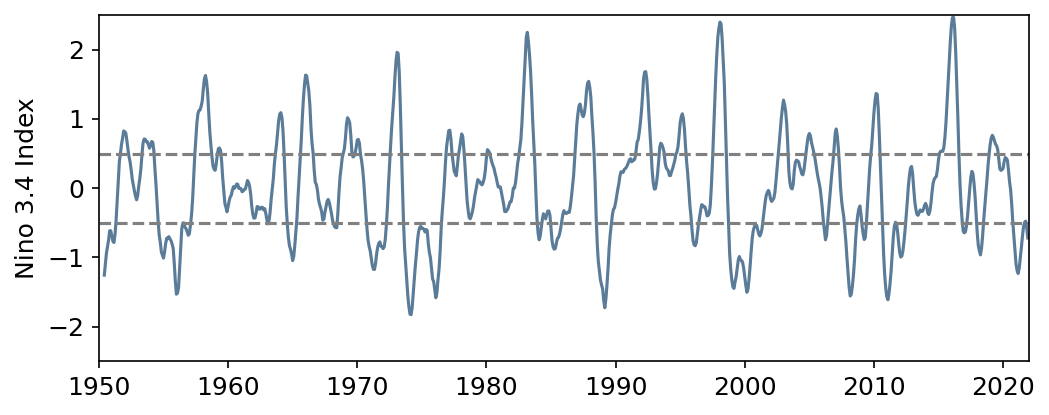

In [ ]:
filename = 'ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc'
sstds = xr.open_dataset(filename,decode_times=False)
sst = sstds.sst
sst = sst.where((sst.lat <= 30) & (sst.lat >= -30), drop=True)
lat = np.asarray(sst.lat)
lon = np.asarray(sst.lon)
time = sstds.time

ninolat1 = -5
ninolat2 = 5
ninolon1 = 190
ninolon2 = 240

sstnino = np.asarray(sst.sel(lat=slice(ninolat1,ninolat2),lon=slice(ninolon1,ninolon2)))
nino34 = np.nanmean(sstnino,axis=(1,2))
timevec = np.arange(1950+(5/12),2022,1/12)

plt.figure(figsize=(8,3))
plt.plot(timevec,nino34,color='xkcd:slate blue')
plt.hlines(0.5,1950,2022,linestyle='dashed',color='grey')
plt.hlines(-0.5,1950,2022,linestyle='dashed',color='grey')
plt.xlim(1950,2022)
plt.ylim(-2.5,2.5)
plt.ylabel("Nino 3.4 Index")
plt.show()

In [ ]:
nino_occur = nino34[(nino34>0.5) | (nino34<-0.5)] # only samples where nino event occurs
nino_occur[nino_occur>0.5] = 1 # make into categorical format, 1 for El Nino and 0 for La Nina
nino_occur[nino_occur<0.5] = 0
nino_occur = tf.keras.utils.to_categorical(nino_occur) # format accepted by NN
sizefull = nino_occur.shape[0]

train_val_test = [0.7,0.85,1] # set train/val/test fraction

sst = np.asarray(sst)
sizesst = sst.shape
sstnino_occur = sst[(nino34>0.5) | (nino34<-0.5),:,:] # grab sst samples where nino occurs
sstnino_occur = np.reshape(sstnino_occur,(sizefull,sizesst[1]*sizesst[2])) # reshape latxlon to vectors

trainind = range(int(train_val_test[0]*sizefull))
valind = range(int(train_val_test[0]*sizefull),int(train_val_test[1]*sizefull))
testind = range(int(train_val_test[1]*sizefull),int(train_val_test[2]*sizefull))

# divide into training/validation/testing
sst_train = sstnino_occur[trainind,:]
sst_val = sstnino_occur[valind,:]
sst_test = sstnino_occur[testind,:]

nino_train  = nino_occur[trainind]
nino_val = nino_occur[valind]
nino_test = nino_occur[testind]

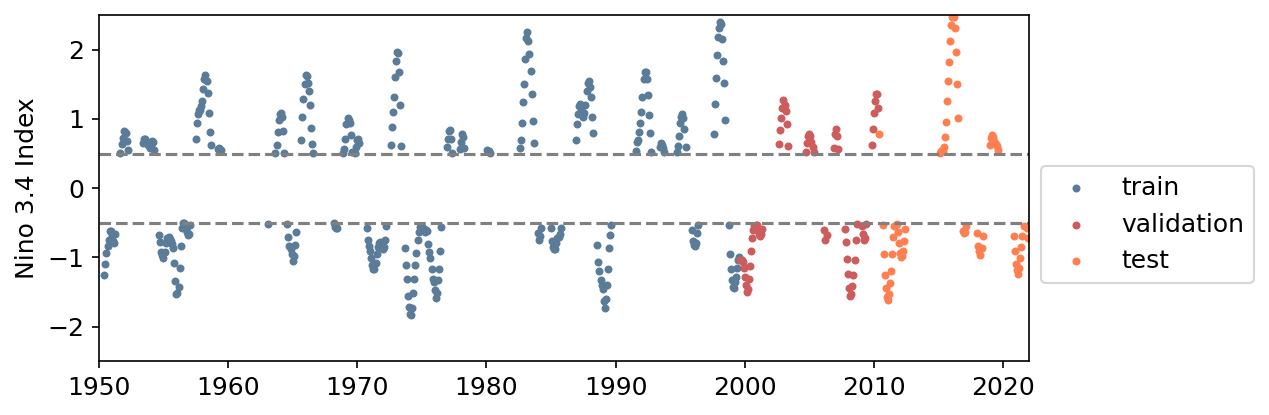

In [ ]:
plt.figure(figsize=(8,3))
plt.scatter(timevec[(nino34>0.5) | (nino34<-0.5)][trainind],nino34[(nino34>0.5) | (nino34<-0.5)][trainind],color='xkcd:slate blue', s=8, label = "train")
plt.scatter(timevec[(nino34>0.5) | (nino34<-0.5)][valind],nino34[(nino34>0.5) | (nino34<-0.5)][valind],color='indianred', s=8, label = "validation")
plt.scatter(timevec[(nino34>0.5) | (nino34<-0.5)][testind],nino34[(nino34>0.5) | (nino34<-0.5)][testind],color='coral', s=8, label = "test")
plt.hlines(0.5,1950,2022,linestyle='dashed',color='grey')
plt.hlines(-0.5,1950,2022,linestyle='dashed',color='grey')
plt.xlim(1950,2022)
plt.ylim(-2.5,2.5)
plt.ylabel("Nino 3.4 Index")
plt.legend(bbox_to_anchor=(1, 0.4, .1, 0.2))
plt.show()

In [ ]:
sst_std = np.std(sst_train,axis=0) # standardized by the TRAINING STD

sst_train = np.divide(sst_train,sst_std)
sst_train[np.isnan(sst_train)] = 0 # set all nans to zeros (they are learned to be ignored)
sst_val = np.divide(sst_val,sst_std)
sst_val[np.isnan(sst_val)] = 0
sst_test = np.divide(sst_test,sst_std)
sst_test[np.isnan(sst_test)] = 0

In [ ]:
sst_train = np.reshape(sst_train,(sst_train.shape[0],sizesst[1],sizesst[2],1)).astype('float32') / 6
sst_val = np.reshape(sst_val,(sst_val.shape[0],sizesst[1],sizesst[2],1)).astype('float32') / 6
sst_test = np.reshape(sst_test,(sst_test.shape[0],sizesst[1],sizesst[2],1)).astype('float32') / 6

In [ ]:
def model():
    x_in = Input(shape=(31, 180, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(2, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [ ]:
cnn = model()
cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 31, 180, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 31, 180, 64)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 15, 90, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 45, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 45, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10080)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,580,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,589,794 (9.88 MB)

 Trainable params: 2,589,794 (9.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn.fit(sst_train,  nino_train, batch_size=64, epochs=5)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7363 - loss: 0.4784
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9936 - loss: 0.0234
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9949 - loss: 0.0155
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 548ms/step - accuracy: 1.0000 - loss: 0.0033
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - accuracy: 1.0000 - loss: 0.0013


In [ ]:
# Evaluate the model on test set
score = cnn.evaluate(sst_test, nino_test, verbose=0)
print('Test accuracy: ', score[1]*100)

Test accuracy:  100.0


In [ ]:
nino_pred = cnn.predict(sst_test) # make predictions for test data

nino_pred = np.argmax(nino_pred,axis=1)
nino_true = np.argmax(nino_test,axis=1)

modelcorr = nino_pred==nino_true
nmodelcorr = modelcorr[modelcorr].shape[0]
ntest = nino_true.shape[0]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


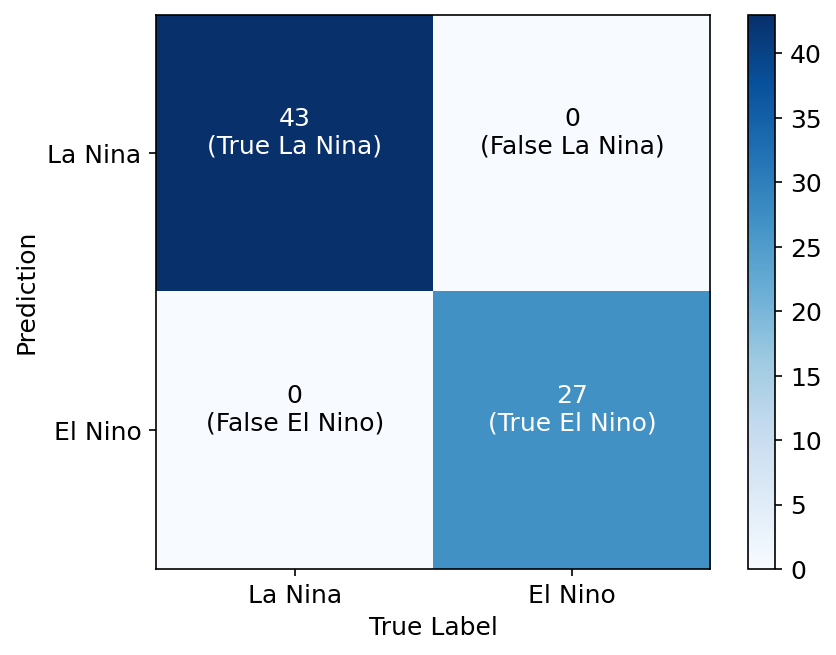

In [ ]:
# confusion matrix

cm = tf.math.confusion_matrix(nino_true, nino_pred).numpy()
plt.imshow(cm, cmap = "Blues")
plt.text(x = 0, y = 0, s=str(cm[0,0]) + "\n(True La Nina)", color = "w", ha = "center")
plt.text(x = 0, y = 1, s=str(cm[0,1]) + "\n(False El Nino)", ha = "center")
plt.text(x = 1, y = 0, s=str(cm[1,0]) + "\n(False La Nina)", ha = "center")
plt.text(x = 1, y = 1, s=str(cm[1,1]) + "\n(True El Nino)", color = "w", ha = "center")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.colorbar()
plt.xticks((0,1), labels = ["La Nina", "El Nino"])
plt.yticks((0,1), labels = ["La Nina", "El Nino"]);

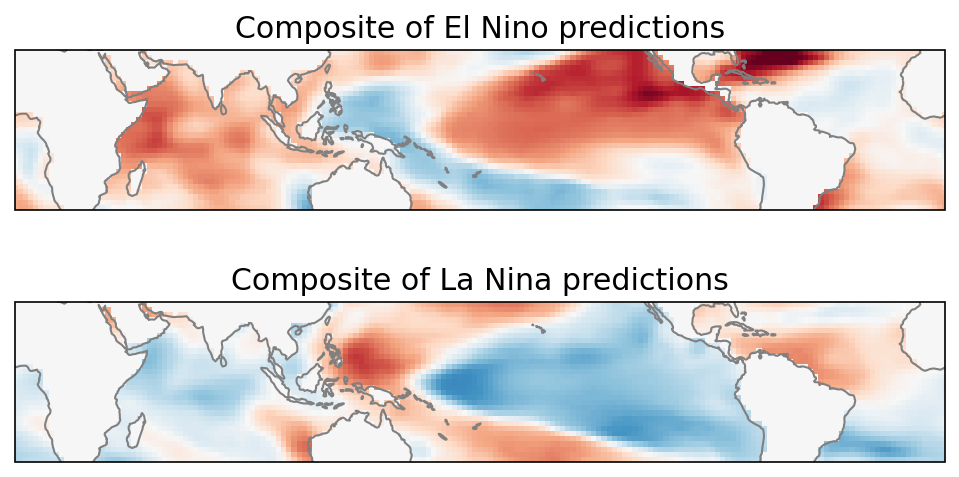

In [ ]:
elninopred = (nino_pred==1)
laninapred = (nino_pred==0)

elnino_sst = sst_test[elninopred,:]
elnino_sst = np.reshape(elnino_sst,(elnino_sst.shape[0],sizesst[1],sizesst[2]))
lanina_sst = sst_test[laninapred,:]
lanina_sst = np.reshape(lanina_sst,(lanina_sst.shape[0],sizesst[1],sizesst[2]))

elninoplot = np.mean(elnino_sst,axis=0)
laninaplot = np.mean(lanina_sst,axis=0)

projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()

plt.figure(figsize=(8,4))

ax1=plt.subplot(2,1,1,projection=projection)
ax1.pcolormesh(lon,lat,elninoplot*6,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Composite of El Nino predictions')

ax2=plt.subplot(2,1,2,projection=projection)
ax2.pcolormesh(lon,lat,laninaplot*6,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax2.coastlines(color='gray')
plt.title('Composite of La Nina predictions')

plt.show()

In [ ]:
! pip install alibi
from alibi.explainers import AnchorImage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.6 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 24.2.0
    Uninstalling attrs-24.2.0:
      Successfully uninstalled attrs-24.2.0
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.24.0
    Uninstalling scikit-image-0.24.0:
      Successfully uninstalled scikit-image-0.24.0


In [ ]:
preds = cnn.predict(sst_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


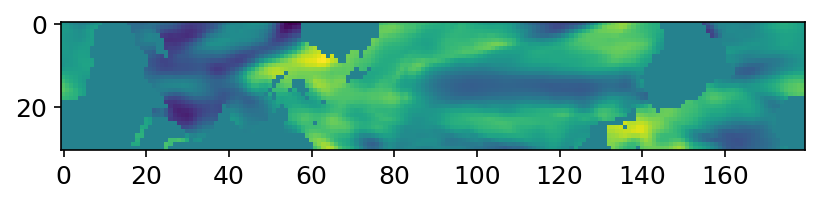

In [ ]:
plt.imshow(sst_test[40,:,:,0])

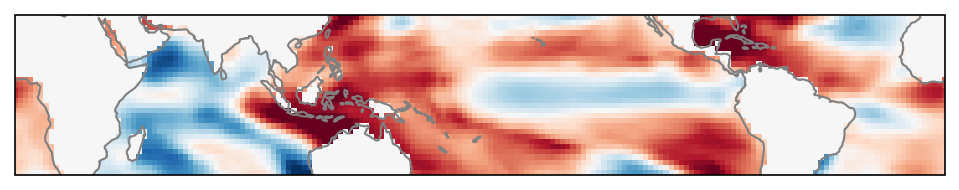

In [ ]:
plt.figure(figsize=(8,4))
projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()

ax1=plt.subplot(2,1,1,projection=projection)
ax1.pcolormesh(lon,lat,sst_test[40,:,:,0]*6,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')

In [ ]:
cnn.predict(sst_test[40].reshape(1, 31, 180, 1)).argmax()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


0

In [ ]:
cnn.predict(sst_test[42].reshape(1, 31, 180, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([[0.97317344, 0.02682663]], dtype=float32)

In [ ]:
image_shape = (sst_train.shape[1],sst_train.shape[2], 1)
predict_fn = lambda x: cnn.predict(x)

explainer = AnchorImage(predict_fn, image_shape, segmentation_fn='slic')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [ ]:
idx = 42

explanation = explainer.explain(sst_test[idx,:,:,:], threshold=.99999, p_sample=.9, seed=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step 


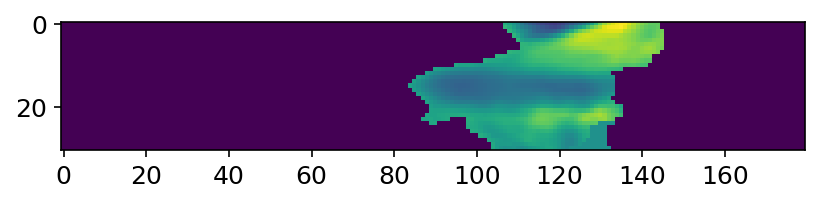

In [ ]:
plt.imshow(explanation.anchor[:,:,0]);

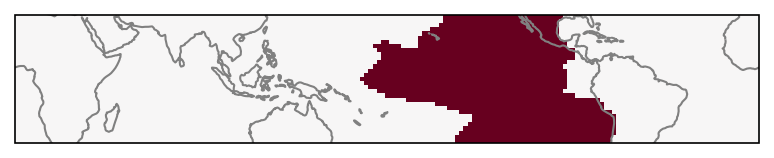

In [ ]:
ax1=plt.subplot(2,1,1,projection=projection)
ax1.pcolormesh(lon,lat,explanation.anchor[:,:,0],vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')

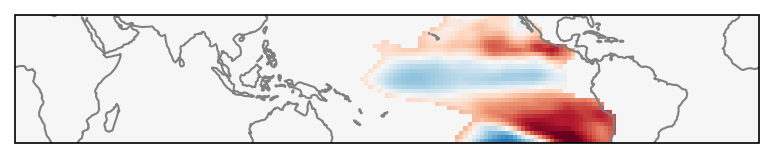

In [ ]:
# prompt: change any value greater than 0 in explanation.anchor to 1
explanation.anchor[explanation.anchor > 0] = 1

#plot the anchor area
ax1=plt.subplot(2,1,1,projection=projection)
ax1.pcolormesh(lon,lat,explanation.anchor[:,:,0] * sst_test[idx,:,:,0]*6,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')

In [ ]:
cnn.predict((explanation.anchor[:,:,0] * sst_test[idx,:,:,0]).reshape(1, 31, 180, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


array([[0.05106379, 0.9489363 ]], dtype=float32)

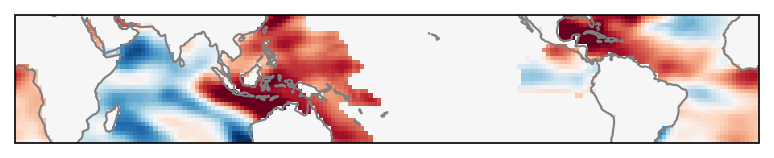

In [ ]:
# prompt: change any value greater than 0 in explanation.anchor to 1
explanation.anchor[explanation.anchor > 0] = 1

#plot the anchor area
ax1=plt.subplot(2,1,1,projection=projection)
ax1.pcolormesh(lon,lat,((explanation.anchor[:,:,0]-1)*-1) * sst_test[40,:,:,0]*6,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')

In [ ]:
cnn.predict(((explanation.anchor-1)*-1 * sst_test[idx]).reshape(1, 31, 180, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


array([[0.8890301, 0.1109699]], dtype=float32)

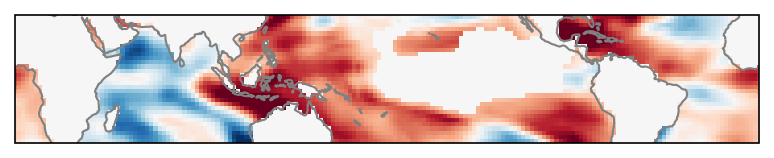

In [ ]:
val = ((explanation.anchor-1)*-1 * sst_test[40]).reshape(1, 31, 180, 1)

#plot the anchor area
ax1=plt.subplot(2,1,1,projection=projection)
ax1.pcolormesh(lon,lat,val[0,:,:,0]*6,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')

In [ ]:
vals = ((elninoplot * (explanation.anchor[:,:,0]-1)*-1) + (explanation.anchor[:,:,0] * sst_test[40,:,:,0]))*6

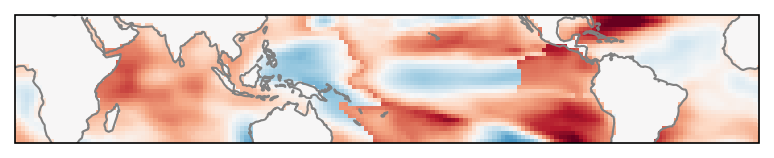

In [ ]:
#plot the anchor area
ax1=plt.subplot(2,1,1,projection=projection)
ax1.pcolormesh(lon,lat,vals,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')

In [ ]:
cnn.predict(vals.reshape(1, 31, 180, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


array([[1.5225418e-27, 1.0000000e+00]], dtype=float32)

In [ ]:
anchor_images = []
anchor_index = []

for i in range(len(sst_test)):

  explanation = explainer.explain(sst_test[i,:,:,:], threshold=.80, p_sample=.9, seed=0)

  if np.max(explanation.anchor) !=0:
    anchor_images.append(explanation.anchor)
    anchor_index.append(i)
    print(i)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━

In [ ]:
print(len(anchor_images))

4
